In [ ]:
!pip install "jax[cpu]"==0.3.7 # need to use older version of jax fix temporary jax2tf bug (should be fixed in 0.3.11 release): "AttributeError: module 'tensorflow.compiler.tf2xla.python.xla' has no attribute 'optimization_barrier'"

In [ ]:
!pip install -q git+https://github.com/google-research/vision_transformer

In [ ]:
!pip install -U tf2onnx

In [ ]:
import jax
import jax.numpy as jnp
from jax.experimental import jax2tf
import tensorflow as tf
from vit_jax import models
import tf2onnx

In [ ]:
# Currently available LiT models
[name for name in models.model_configs.MODEL_CONFIGS if name.startswith('LiT')]

['LiT-B16B', 'LiT-L16L', 'LiT-L16S', 'LiT-L16Ti']

In [ ]:
model_name = 'LiT-B16B'
lit_model = models.get_model(model_name)
lit_variables = lit_model.load_variables()
tokenizer = lit_model.get_tokenizer() # <-- this contains tensorflow code, so need to port manually :(
image_preprocessing = lit_model.get_image_preprocessing() # <-- this contains tensorflow code, so need to port manually :(

In [ ]:
##################################
#         IMAGE MODEL            #
##################################

In [ ]:
def embed_images(variables, images):
  zimg, _, _ = lit_model.apply(variables, images=images)
  return zimg

In [ ]:
# This is so we don't save the model parameters as graph constants. Explanation here: https://github.com/google/jax/tree/main/jax/experimental/jax2tf#saved-model-with-parameters
lit_variables_tf = tf.nest.map_structure(tf.Variable, lit_variables)
embed_images_tf = lambda images: jax2tf.convert(embed_images, enable_xla=False, polymorphic_shapes=[None, "(b, ...)"])(lit_variables_tf, images)

In [ ]:
!wget https://i.imgur.com/qJxtpBA.jpg

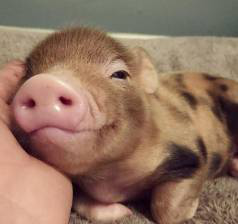

In [ ]:
from PIL import Image
img = Image.open("/content/qJxtpBA.jpg") 
display(img)

In [ ]:
np_img = jnp.asarray(img)

In [ ]:
print(np_img.shape)

(224, 238, 3)


In [ ]:
pp_img = image_preprocessing(tf.convert_to_tensor(jnp.array([np_img])))

In [ ]:
pp_img.shape

(1, 224, 224, 3)

In [ ]:
embed_images_tf(pp_img)

In [ ]:
my_model = tf.Module()
my_model._variables = tf.nest.flatten(lit_variables_tf)
my_model.f = tf.function(embed_images_tf, autograph=False, jit_compile=True, input_signature=[
  tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name="images"),
])

model_name = 'embed_images'
tf.saved_model.save(my_model, model_name, options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

INFO:tensorflow:Assets written to: embed_images/assets


INFO:tensorflow:Assets written to: embed_images/assets


In [ ]:
# https://github.com/onnx/tensorflow-onnx#from_function-tf-20-and-newer
tf2onnx.convert.from_function(my_model.f, input_signature=[tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name="images")], opset=13, output_path=model_name+'.onnx')

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/embed_images.onnx /content/drive/MyDrive/embed_images.onnx

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
# tflite_model = converter.convert()

# with open(model_name+'.tflite', 'wb') as f:
#   f.write(tflite_model)

In [ ]:
##################################
#          TEXT MODEL            #
##################################

In [ ]:
def embed_text_tokens(variables, text_tokens):
  _, ztxt, _ = lit_model.apply(lit_variables, tokens=text_tokens)
  return ztxt

In [ ]:
# This is so we don't save the model parameters as graph constants. Explanation here: https://github.com/google/jax/tree/main/jax/experimental/jax2tf#saved-model-with-parameters
lit_variables_tf = tf.nest.map_structure(tf.Variable, lit_variables)
embed_text_tokens_tf = lambda text_tokens: jax2tf.convert(embed_text_tokens, enable_xla=False, polymorphic_shapes=[None, "(b, ...)"])(lit_variables_tf, text_tokens)

In [ ]:
texts = ["hello world!", "testing one two three", "hi", "aaaaaaaaaaaaaaaa"]

In [ ]:
text_tokens = tokenizer(texts)
text_tokens.shape

(4, 16)

In [ ]:
_, ztxt, _ = lit_model.apply(lit_variables, tokens=text_tokens)

In [ ]:
text_tokens

array([[  101,  7592,  2088,   999,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  101,  5604,  2028,  2048,  2093,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  101,  7632,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  101, 13360, 11057, 11057, 11057, 11057, 11057, 11057,  2050,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)

In [ ]:
embed_text_tokens_tf(text_tokens)

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.00325142,  0.01848885,  0.00041978, ...,  0.00173793,
        -0.00536559, -0.06884101],
       [-0.01331316,  0.01797788,  0.00657475, ...,  0.00655348,
         0.02183297, -0.08194969],
       [ 0.00275494,  0.0236993 ,  0.0011628 , ...,  0.00860824,
         0.00814609, -0.05825125],
       [ 0.00415286,  0.00938824, -0.00084121, ...,  0.01578477,
         0.0134029 , -0.06656414]], dtype=float32)>

In [ ]:
my_model = tf.Module()
my_model._variables = tf.nest.flatten(lit_variables_tf)
my_model.f = tf.function(embed_text_tokens_tf, autograph=False, jit_compile=True, input_signature=[
  tf.TensorSpec(shape=[None, 16], dtype=tf.int32, name="text_tokens"),
])

model_name = 'embed_text_tokens'
tf.saved_model.save(my_model, model_name, options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

INFO:tensorflow:Assets written to: embed_text_tokens/assets


INFO:tensorflow:Assets written to: embed_text_tokens/assets


In [ ]:
# https://github.com/onnx/tensorflow-onnx#from_function-tf-20-and-newer
tf2onnx.convert.from_function(my_model.f, input_signature=[tf.TensorSpec(shape=[None, 16], dtype=tf.int32, name="text_tokens")], opset=13, output_path=model_name+'.onnx')

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/embed_text_tokens.onnx /content/drive/MyDrive/embed_text_tokens.onnx

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
# tflite_model = converter.convert()

# with open(model_name+'.tflite', 'wb') as f:
#   f.write(tflite_model)

In [ ]:
#!python -m tf2onnx.convert --opset 13 --tflite embed_images.tflite --output embed_images.onnx # fails due to lack of TFL_BATCH_MATMUL support: https://github.com/onnx/tensorflow-onnx/issues/1925